# Enhancing NHL Salary Evaluation through Dimensionality Reduction  
Raphaël Fontaine  
McGill University  
Montreal, Canada  
raphael.fontaine@mail.mcgill.ca  

# Principal Component Analysis (PCA)

In [39]:
import common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import Markdown

In [40]:
df = common.load_dataset()

# Split features and label
X_data, y_data = common.split_dataset(df)

X_columns = X_data.columns

# Split train and test data
X_train, y_train, X_test, y_test = common.split_train_test(X_data, y_data)

# Standardize the features
X_train, X_test = common.standard_scaler(X_train, X_test)

## Implementation 1: Singular Value Decomposition

In [41]:
X = X_train.copy()
n_samples, n_features = X.shape

# Center the data (subtract the mean of each feature)
X_centered = X - np.mean(X, axis=0)

# Singular Value Decomposition
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

# Compute explained variance
explained_variance = (S**2) / (n_samples-1)
total_explained_variance = np.sum(explained_variance)
explained_variance_ratio = explained_variance / total_explained_variance

# Compute cumulative explained variance
cumsum = np.cumsum(explained_variance_ratio)
x_range = range(0, len(cumsum))

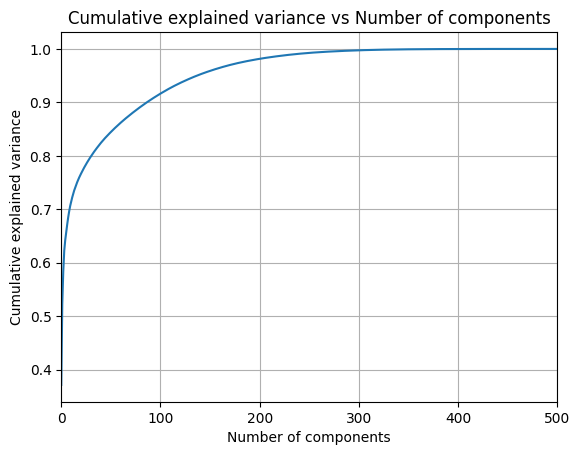

In [42]:
plt.clf()
plt.plot(range(0, len(cumsum)), cumsum)
plt.title("Cumulative explained variance vs Number of components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.xlim(0, 500)
plt.grid()
plt.show()

In [43]:
str_output = ""

# Get the top 10 contributing features for the first 5 principal components
for i in range(5):
    # Get the component (row of Vt)
    component = Vt[i]
    
    # Get the indices of the top 10 contributing features
    top_features_idx = np.argsort(np.abs(component))[-10:][::-1]
    
    # Print the top 10 contributing features for the i-th principal component
    str_output += f"### Principal Component {i+1}:\n"
    str_output += f"Explained Variance: {explained_variance[i]:.4f}<br>"
    str_output += f"Explained Variance Ratio: {explained_variance_ratio[i]:.4f}<br>"
    str_output += f"Cumulative Explained Variance: {cumsum[i]:.4f}\n"

Markdown(str_output)

### Principal Component 1:
Explained Variance: 283.8259<br>Explained Variance Ratio: 0.3714<br>Cumulative Explained Variance: 0.3714
### Principal Component 2:
Explained Variance: 115.4110<br>Explained Variance Ratio: 0.1510<br>Cumulative Explained Variance: 0.5224
### Principal Component 3:
Explained Variance: 46.7740<br>Explained Variance Ratio: 0.0612<br>Cumulative Explained Variance: 0.5836
### Principal Component 4:
Explained Variance: 29.8602<br>Explained Variance Ratio: 0.0391<br>Cumulative Explained Variance: 0.6227
### Principal Component 5:
Explained Variance: 15.2144<br>Explained Variance Ratio: 0.0199<br>Cumulative Explained Variance: 0.6426


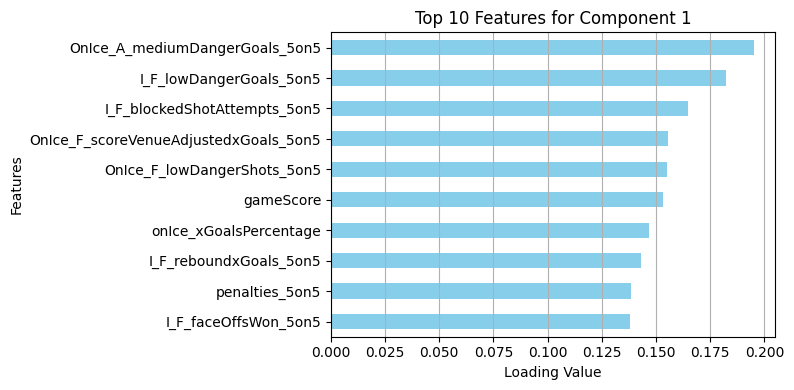

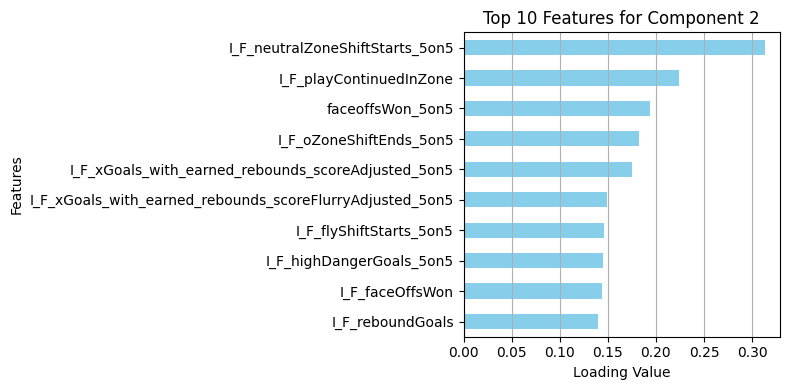

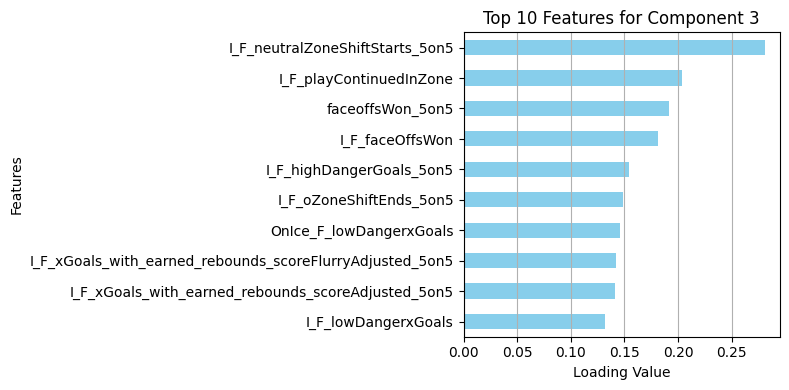

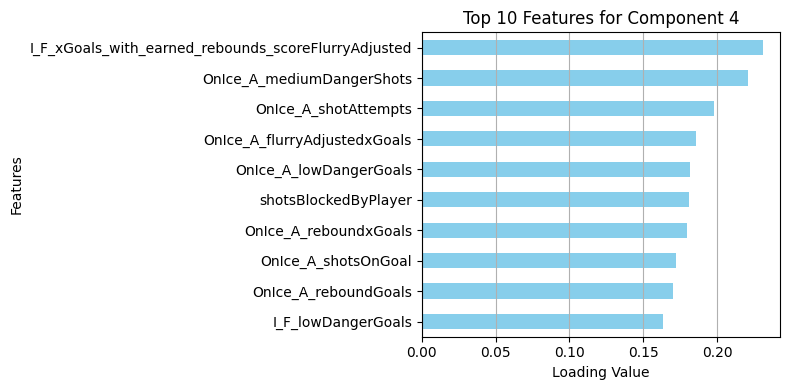

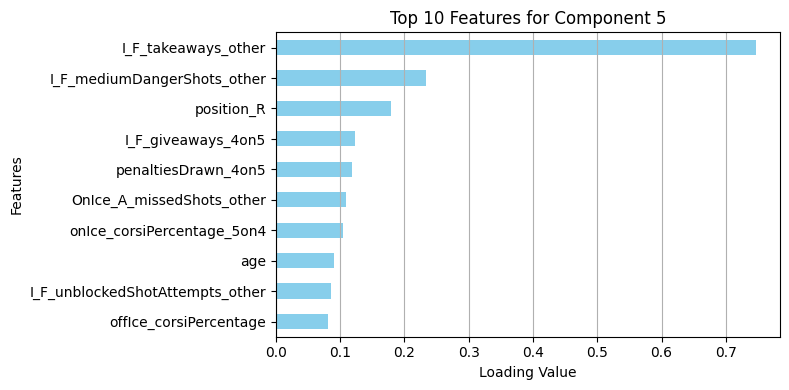

In [44]:
n_top_features = 10

loadings_df = pd.DataFrame(Vt, index=X_data.columns)

for comp in range(5):
    plt.figure(figsize=(8, 4))
    # Sort features by absolute loading values for the current component
    top_features = loadings_df.iloc[:, comp].abs().nlargest(n_top_features)
    
    # Plot
    top_features.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f"Top {n_top_features} Features for Component {comp + 1}")
    plt.xlabel("Loading Value")
    plt.ylabel("Features")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [45]:
variance_thresholds = [0.25, 0.50, 0.75, 0.90, 0.95]

results = []
for variance_threshold in variance_thresholds:
    # Select the components
    selected_components = np.where(cumsum >= variance_threshold)[0][0] + 1

    # Transform data into principal component space
    X_train_pca = np.dot(X_centered, Vt.T)
    X_train_pca = X_train_pca[:, :selected_components]

    # Adjust the features for testing
    X_test_centered = X_test - np.mean(X, axis=0)
    X_test_pca = np.dot(X_test_centered, Vt.T)
    X_test_pca = X_test_pca[:, :selected_components]

    # Train and evaluate the model
    results_df, predictions = common.train_and_evaluate(X_train_pca, y_train, X_test_pca, y_test)

    results_df["Components"] = selected_components
    results_df["Threshold"] = variance_threshold

    results.append(results_df)

results_df = pd.concat(results)
results_df.groupby(by="Threshold")[results_df.columns].apply(lambda x: x).drop(columns=["Threshold"])

R2        MAE Top-100 MAE Top-50 MAE  \
Threshold Model                                                           
0.25      Linear Regression    0.4851  1,524,628   1,913,240  2,537,464   
          Random Forest        0.2606  1,780,485   2,165,465  2,705,744   
          Support Vector       0.5016  1,482,780   1,966,063  2,577,555   
          K-Nearest Neighbors  0.3487  1,663,351   2,012,112  2,481,525   
0.50      Linear Regression    0.4986  1,496,771   1,869,011  2,339,426   
          Random Forest        0.4717  1,509,837   1,896,849  2,393,731   
          Support Vector       0.5150  1,457,700   1,879,472  2,343,895   
          K-Nearest Neighbors  0.4611  1,515,137   1,894,536  2,398,909   
0.75      Linear Regression    0.5675  1,334,535   1,834,847  2,284,677   
          Random Forest        0.5535  1,383,525   1,931,416  2,534,001   
          Support Vector       0.5680  1,322,788   1,863,102  2,357,359   
          K-Nearest Neighbors  0.5598  1,344,158   1,905,473  2,489,060   
0.90      Linear Regression    0.5684  1,341,923   1,917,990  2,377,233   
          Random Forest        0.4906  1,505,292   2,266,730  2,995,644   
          Support Vector       0.5681  1,325,428   1,912,240  2,432,140   
          K-Nearest Neighbors  0.5611  1,353,952   2,033,402  2,548,211   
0.95      Linear Regression    0.5799  1,306,634   1,858,033  2,361,751   
          Random Forest        0.4613  1,551,825   2,373,857  3,190,814   
          Support Vector       0.5947  1,275,063   1,819,979  2,366,959   
          K-Nearest Neighbors  0.5508  1,360,359   2,023,507  2,606,079   

                                SMAPE  Train time (sec)  Components  
Threshold Model                                                      
0.25      Linear Regression    0.3866              0.00           1  
          Random Forest        0.4309              0.73           1  
          Support Vector       0.3747              0.41           1  
          K-Nearest Neighbors  0.4086              0.00           1  
0.50      Linear Regression    0.3844              0.00           2  
          Random Forest        0.3784              0.73           2  
          Support Vector       0.3732              0.35           2  
          K-Nearest Neighbors  0.3804              0.00           2  
0.75      Linear Regression    0.3422              0.05          17  
          Random Forest        0.3538              2.20          17  
          Support Vector       0.3374              0.52          17  
          K-Nearest Neighbors  0.3423              0.00          17  
0.90      Linear Regression    0.3383              0.17          88  
          Random Forest        0.3815              4.44          88  
          Support Vector       0.3339              0.72          88  
          K-Nearest Neighbors  0.3450              0.00          88  
0.95      Linear Regression    0.3359              0.07         138  
          Random Forest        0.3922              5.58         138  
          Support Vector       0.3245              0.91         138  
          K-Nearest Neighbors  0.3442              0.00         138

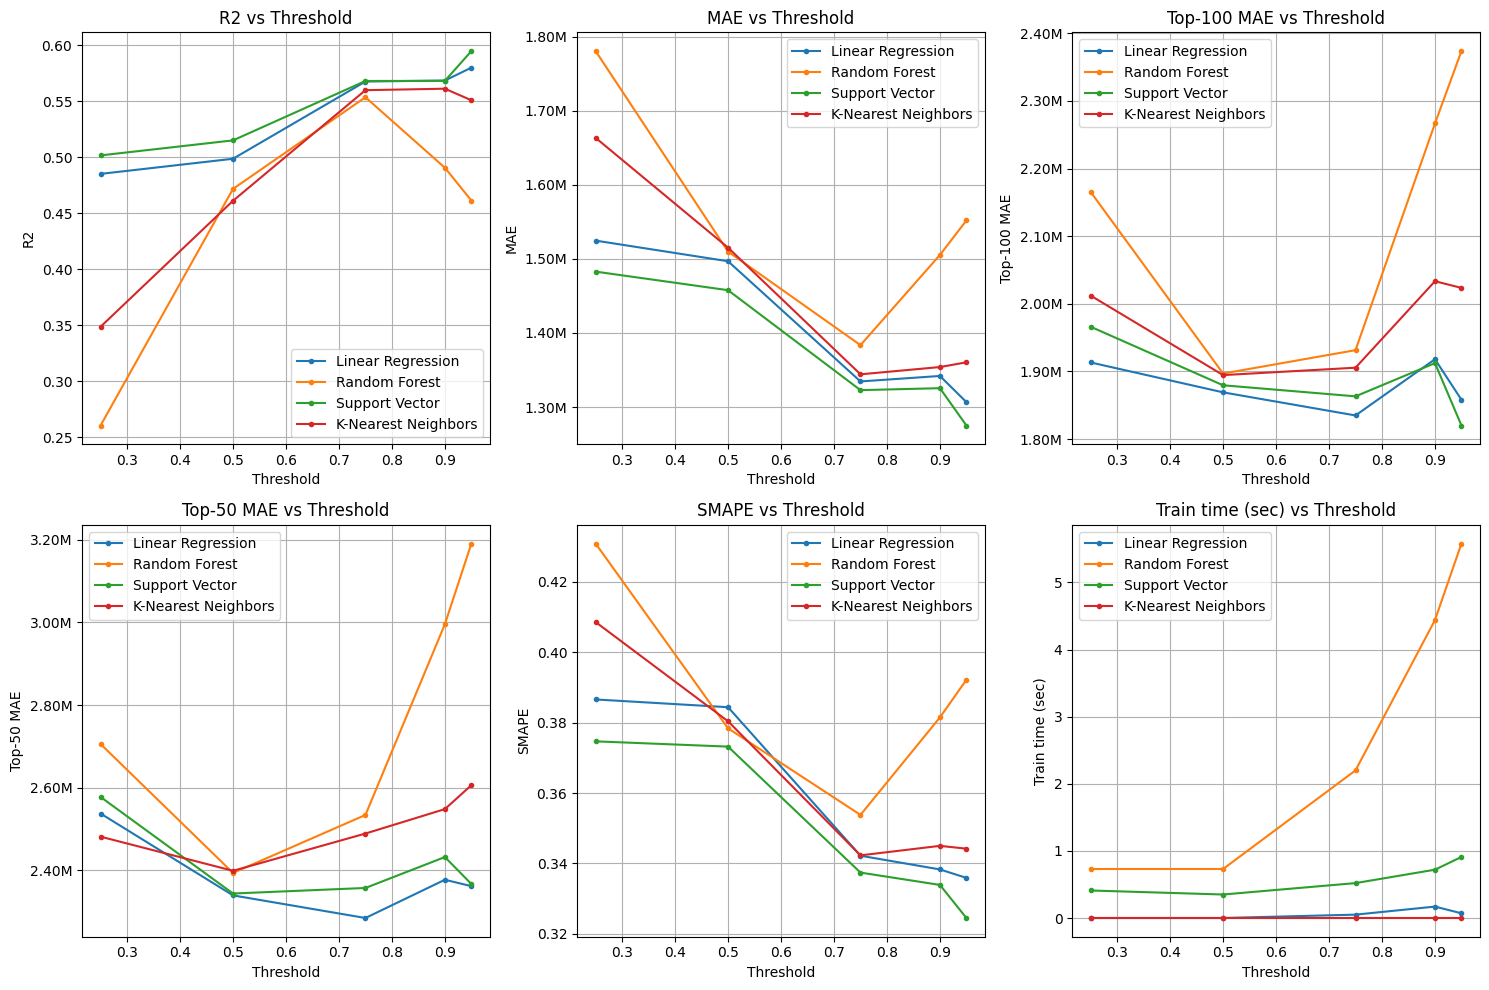

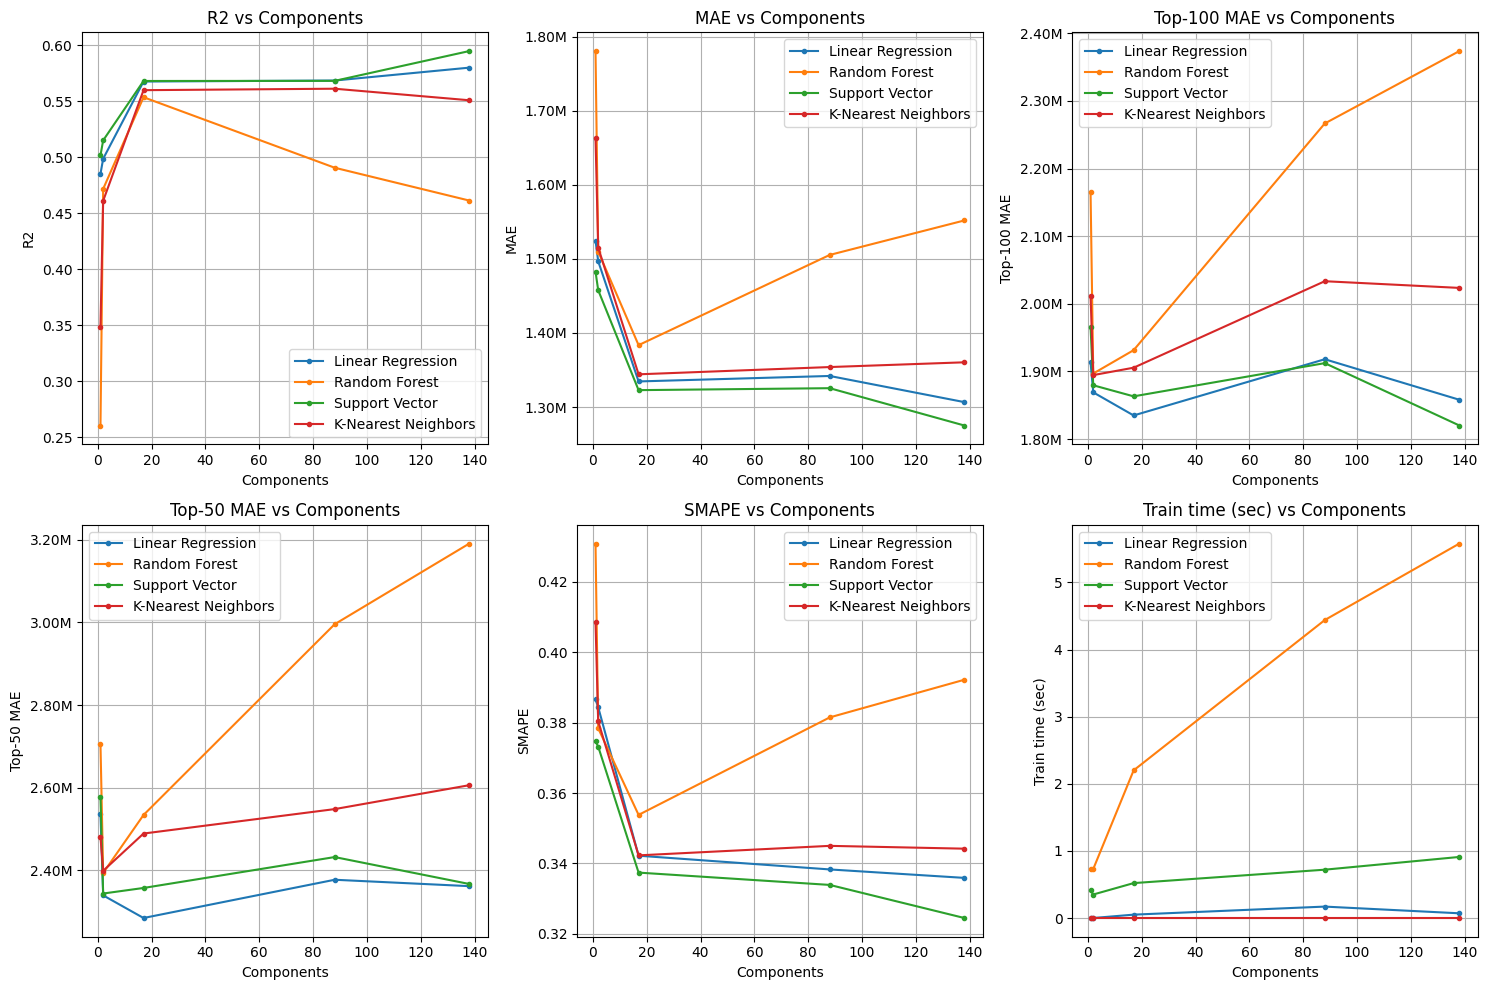

In [46]:
common.plot_metrics(results_df, "Threshold")
common.plot_metrics(results_df, "Components")

## Implementation 2: Covariance Matrix and Eigenvalues

In [47]:
X = X_train.copy()
n_samples, n_features = X.shape

# Center the data (subtract the mean of each feature)
X_centered = X - np.mean(X, axis=0)

# Compute the covariance matrix
C = (X.T @ X)/(n_samples-1)

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(C)

# Sort the eigenvalues and eigenvectors in descending order
eigenvalues = np.flip(eigenvalues, axis=0)
eigenvectors = np.flip(eigenvectors, axis=1)

# Clip to positive for numerical stability
eigenvalues[eigenvalues < 0.0] = 0.0

Vt = eigenvectors.T

# Compute explained variance
explained_variance = eigenvalues
total_explained_variance = np.sum(explained_variance)
explained_variance_ratio = explained_variance / total_explained_variance

# Compute cumulative explained variance
cumsum = np.cumsum(explained_variance_ratio)
x_range = range(0, len(cumsum))

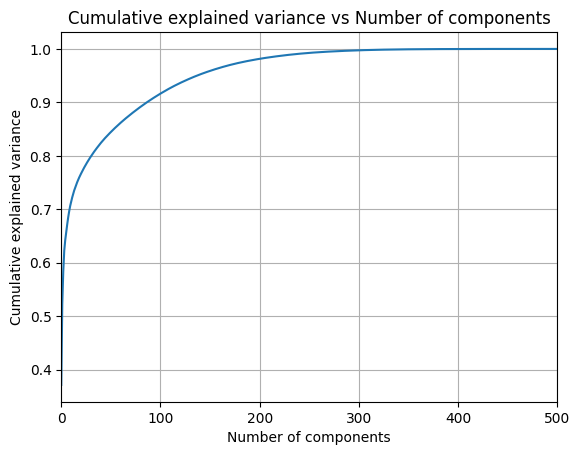

In [48]:
plt.clf()
plt.plot(range(0, len(cumsum)), cumsum)
plt.title("Cumulative explained variance vs Number of components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.xlim(0, 500)
plt.grid()
plt.show()

In [49]:
str_output = ""

# Get the top 10 contributing features for the first 5 principal components
for i in range(5):
    # Get the component (row of Vt)
    component = Vt[i]
    
    # Get the indices of the top 10 contributing features
    top_features_idx = np.argsort(np.abs(component))[-10:][::-1]
    
    # Print the top 10 contributing features for the i-th principal component
    str_output += f"### Principal Component {i+1}:\n"
    str_output += f"Explained Variance: {explained_variance[i]:.4f}<br>"
    str_output += f"Explained Variance Ratio: {explained_variance_ratio[i]:.4f}<br>"
    str_output += f"Cumulative Explained Variance: {cumsum[i]:.4f}\n"

Markdown(str_output)

### Principal Component 1:
Explained Variance: 283.8259<br>Explained Variance Ratio: 0.3714<br>Cumulative Explained Variance: 0.3714
### Principal Component 2:
Explained Variance: 115.4110<br>Explained Variance Ratio: 0.1510<br>Cumulative Explained Variance: 0.5224
### Principal Component 3:
Explained Variance: 46.7740<br>Explained Variance Ratio: 0.0612<br>Cumulative Explained Variance: 0.5836
### Principal Component 4:
Explained Variance: 29.8602<br>Explained Variance Ratio: 0.0391<br>Cumulative Explained Variance: 0.6227
### Principal Component 5:
Explained Variance: 15.2144<br>Explained Variance Ratio: 0.0199<br>Cumulative Explained Variance: 0.6426


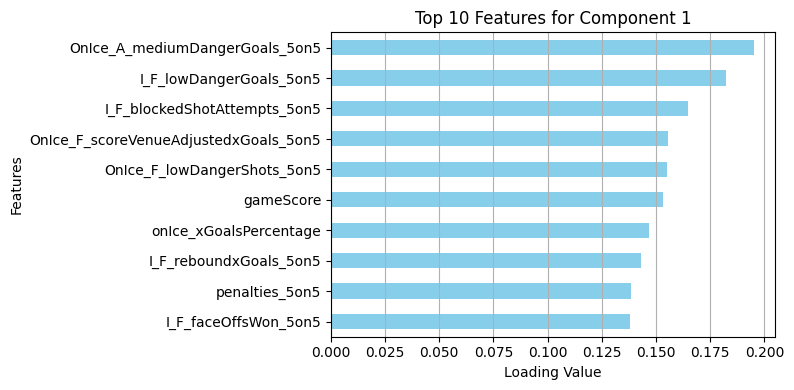

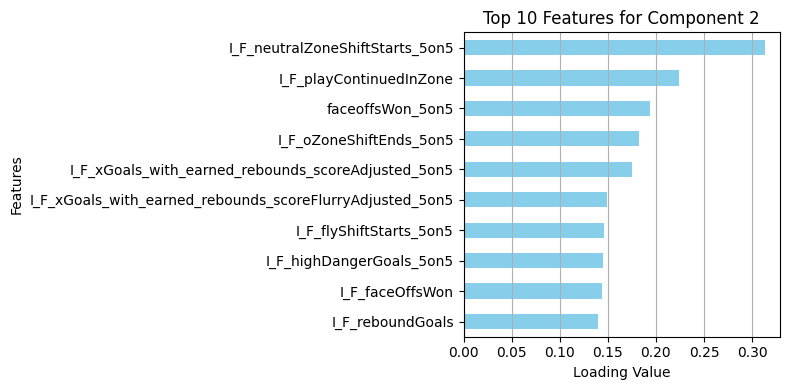

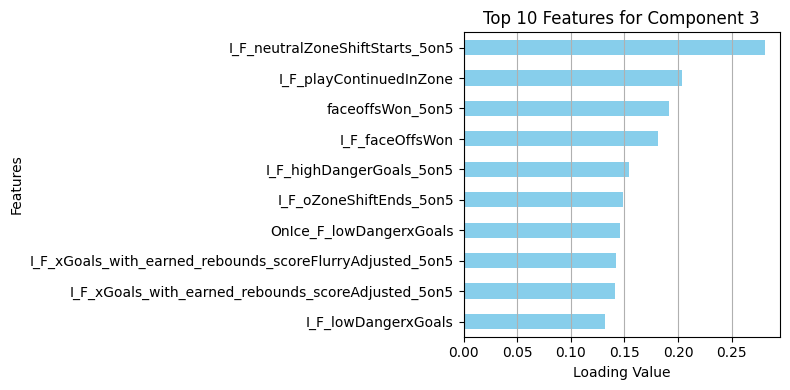

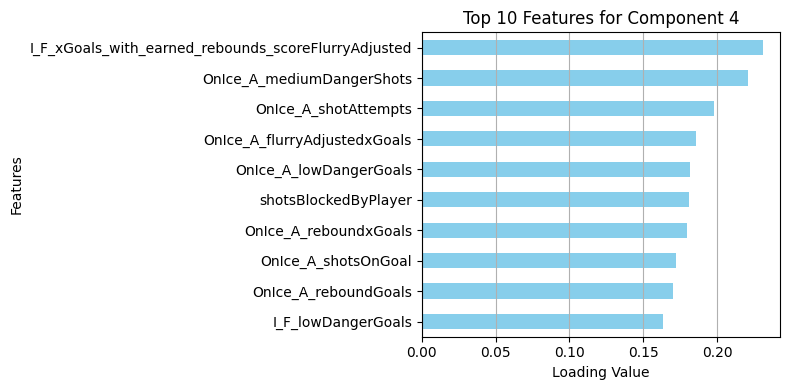

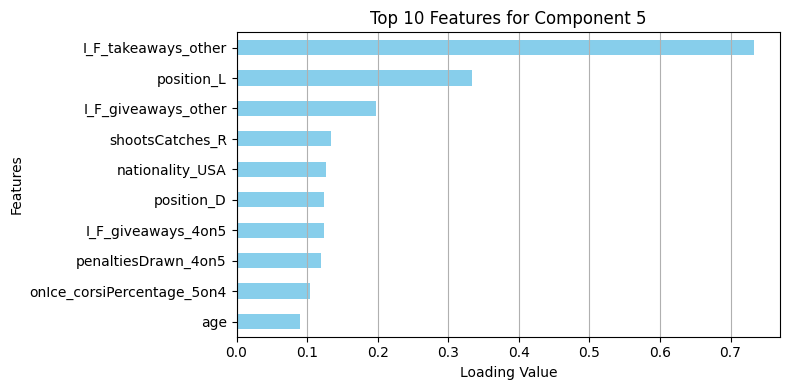

In [50]:
n_top_features = 10

loadings_df = pd.DataFrame(Vt, index=X_data.columns)

for comp in range(5):
    plt.figure(figsize=(8, 4))
    # Sort features by absolute loading values for the current component
    top_features = loadings_df.iloc[:, comp].abs().nlargest(n_top_features)
    
    # Plot
    top_features.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f"Top {n_top_features} Features for Component {comp + 1}")
    plt.xlabel("Loading Value")
    plt.ylabel("Features")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [51]:
results = []
for variance_threshold in variance_thresholds:
    # Select the components
    selected_components = np.where(cumsum >= variance_threshold)[0][0] + 1

    # Transform data into principal component space
    X_train_pca = np.dot(X_centered, Vt.T)
    X_train_pca = X_train_pca[:, :selected_components]

    # Adjust the features for testing
    X_test_centered = X_test - np.mean(X, axis=0)
    X_test_pca = np.dot(X_test_centered, Vt.T)
    X_test_pca = X_test_pca[:, :selected_components]

    # Train and evaluate the model
    results_df, predictions = common.train_and_evaluate(X_train_pca, y_train, X_test_pca, y_test)

    results_df["Components"] = selected_components
    results_df["Threshold"] = variance_threshold

    results.append(results_df)

results_df = pd.concat(results)
results_df.groupby(by="Threshold")[results_df.columns].apply(lambda x: x).drop(columns=["Threshold"])

R2        MAE Top-100 MAE Top-50 MAE  \
Threshold Model                                                           
0.25      Linear Regression    0.4851  1,524,628   1,913,240  2,537,464   
          Random Forest        0.2606  1,780,485   2,165,465  2,705,744   
          Support Vector       0.5016  1,482,780   1,966,063  2,577,555   
          K-Nearest Neighbors  0.3487  1,663,351   2,012,112  2,481,525   
0.50      Linear Regression    0.4986  1,496,771   1,869,011  2,339,426   
          Random Forest        0.4717  1,509,837   1,896,849  2,393,731   
          Support Vector       0.5150  1,457,700   1,879,472  2,343,895   
          K-Nearest Neighbors  0.4611  1,515,137   1,894,536  2,398,909   
0.75      Linear Regression    0.5675  1,334,535   1,834,847  2,284,677   
          Random Forest        0.5406  1,392,487   1,968,800  2,592,782   
          Support Vector       0.5680  1,322,788   1,863,102  2,357,359   
          K-Nearest Neighbors  0.5598  1,344,158   1,905,473  2,489,060   
0.90      Linear Regression    0.5684  1,341,923   1,917,990  2,377,233   
          Random Forest        0.5005  1,481,944   2,250,514  2,994,564   
          Support Vector       0.5681  1,325,428   1,912,240  2,432,140   
          K-Nearest Neighbors  0.5611  1,353,952   2,033,402  2,548,211   
0.95      Linear Regression    0.5799  1,306,634   1,858,033  2,361,751   
          Random Forest        0.4731  1,543,489   2,303,649  3,111,511   
          Support Vector       0.5947  1,275,063   1,819,979  2,366,959   
          K-Nearest Neighbors  0.5508  1,360,359   2,023,507  2,606,079   

                                SMAPE  Train time (sec)  Components  
Threshold Model                                                      
0.25      Linear Regression    0.3866              0.00           1  
          Random Forest        0.4309              0.89           1  
          Support Vector       0.3747              0.44           1  
          K-Nearest Neighbors  0.4086              0.00           1  
0.50      Linear Regression    0.3844              0.02           2  
          Random Forest        0.3784              0.79           2  
          Support Vector       0.3732              0.30           2  
          K-Nearest Neighbors  0.3804              0.00           2  
0.75      Linear Regression    0.3422              0.00          17  
          Random Forest        0.3539              2.14          17  
          Support Vector       0.3374              0.55          17  
          K-Nearest Neighbors  0.3423              0.00          17  
0.90      Linear Regression    0.3383              0.21          88  
          Random Forest        0.3760              5.14          88  
          Support Vector       0.3339              0.97          88  
          K-Nearest Neighbors  0.3450              0.00          88  
0.95      Linear Regression    0.3359              1.39         138  
          Random Forest        0.3922              6.64         138  
          Support Vector       0.3245              1.24         138  
          K-Nearest Neighbors  0.3442              0.00         138

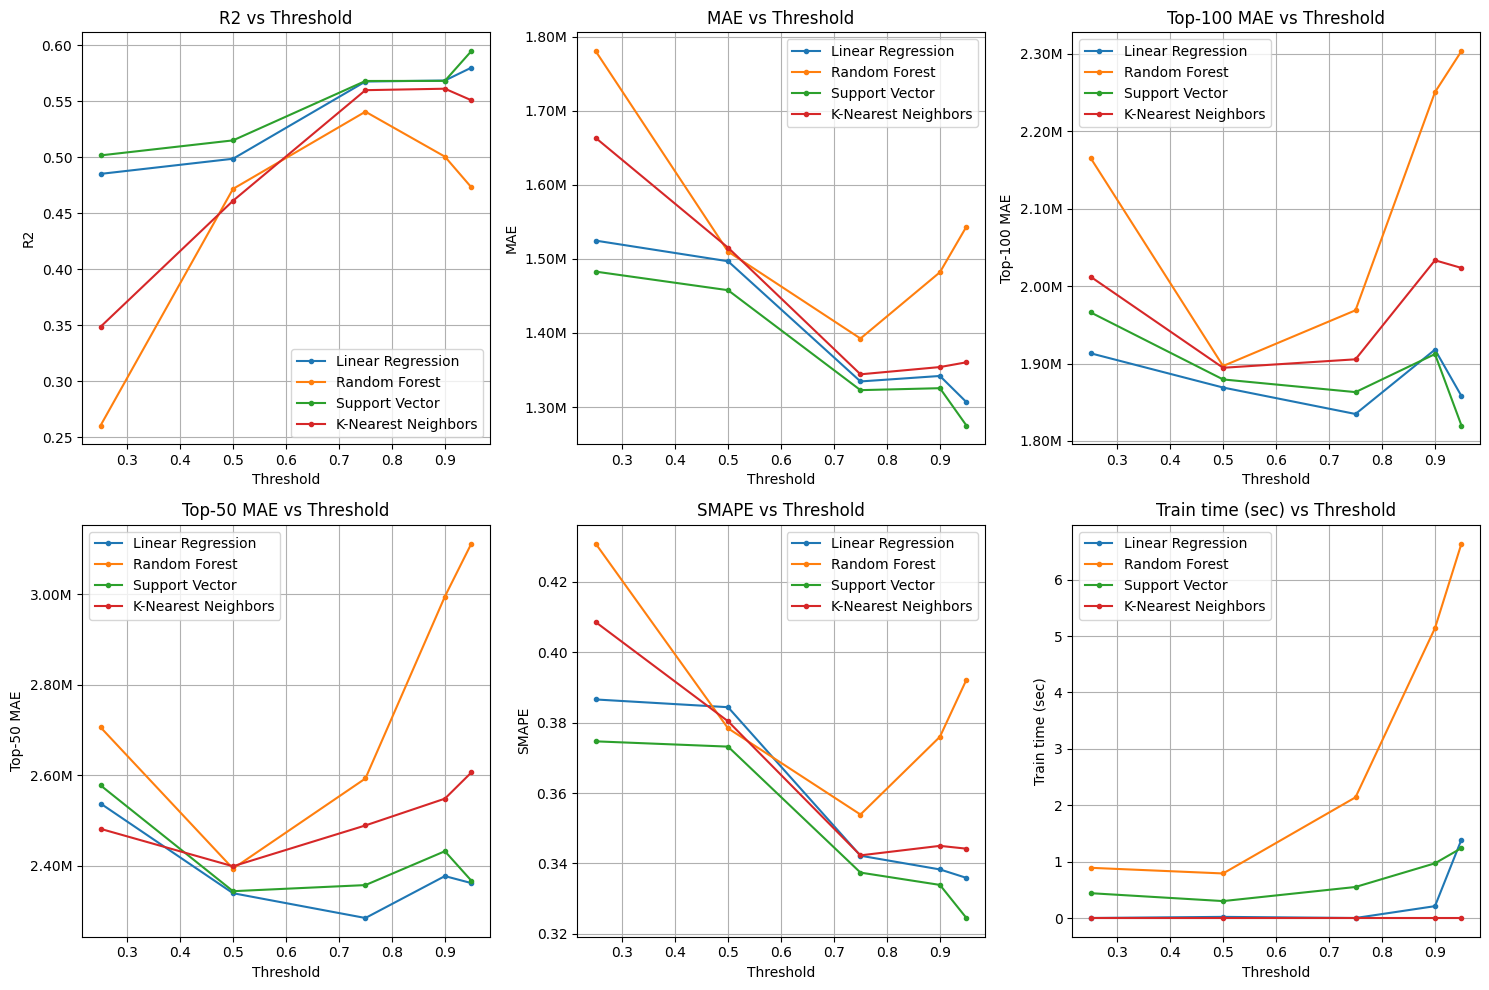

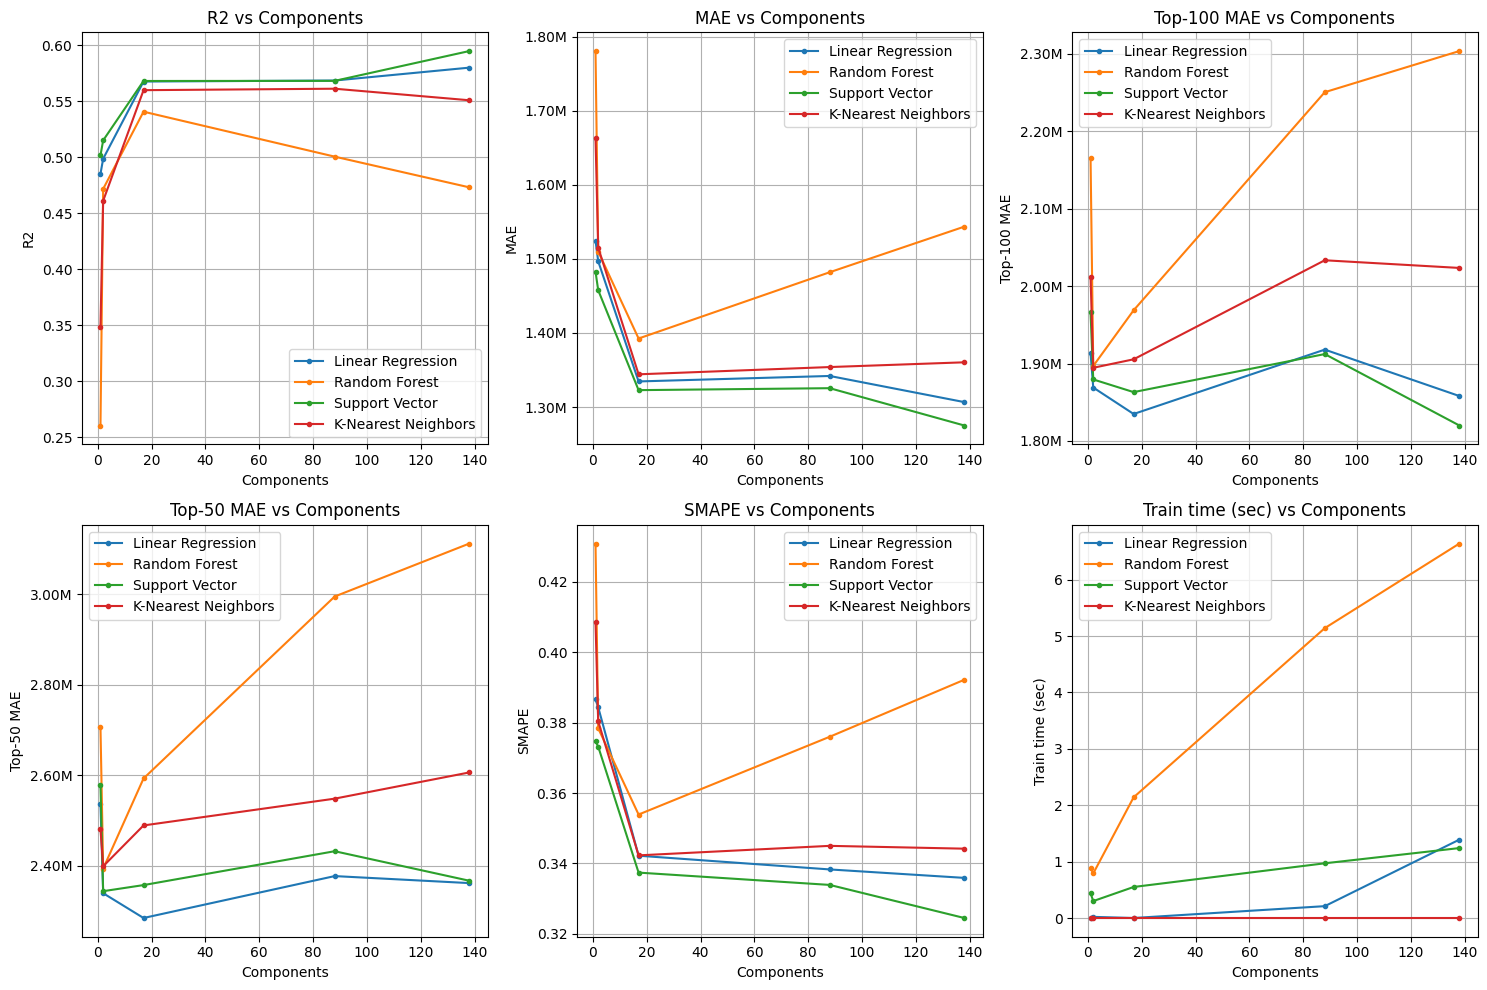

In [52]:
common.plot_metrics(results_df, "Threshold")
common.plot_metrics(results_df, "Components")

## Sklearn PCA

In [53]:
results = []
n_components = results_df["Components"].unique()

for n, variance_threshold in enumerate(variance_thresholds):
    # Apply sklearn PCA
    pca = PCA(n_components=n_components[n])
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Train and evaluate the model
    results_df, predictions = common.train_and_evaluate(X_train_pca, y_train, X_test_pca, y_test)

    results_df["Components"] = n_components[n]
    results_df["Threshold"] = variance_threshold

    results.append(results_df)

results_df = pd.concat(results)
results_df.groupby(by="Threshold")[results_df.columns].apply(lambda x: x).drop(columns=["Threshold"])

R2        MAE Top-100 MAE Top-50 MAE  \
Threshold Model                                                           
0.25      Linear Regression    0.4851  1,524,628   1,913,240  2,537,464   
          Random Forest        0.2606  1,780,485   2,165,465  2,705,744   
          Support Vector       0.5016  1,482,780   1,966,063  2,577,555   
          K-Nearest Neighbors  0.3487  1,663,351   2,012,112  2,481,525   
0.50      Linear Regression    0.4986  1,496,771   1,869,011  2,339,426   
          Random Forest        0.4683  1,518,023   1,883,844  2,329,929   
          Support Vector       0.5150  1,457,700   1,879,472  2,343,895   
          K-Nearest Neighbors  0.4611  1,515,137   1,894,536  2,398,909   
0.75      Linear Regression    0.5674  1,334,550   1,834,987  2,284,685   
          Random Forest        0.5498  1,385,784   1,957,380  2,564,106   
          Support Vector       0.5680  1,322,608   1,863,055  2,357,856   
          K-Nearest Neighbors  0.5595  1,343,853   1,913,891  2,484,131   
0.90      Linear Regression    0.5697  1,331,858   1,801,437  2,269,818   
          Random Forest        0.4882  1,506,402   2,307,259  3,088,640   
          Support Vector       0.5684  1,321,029   1,852,178  2,369,520   
          K-Nearest Neighbors  0.5556  1,353,508   2,013,604  2,551,374   
0.95      Linear Regression    0.5763  1,312,559   1,875,333  2,376,525   
          Random Forest        0.4840  1,522,531   2,330,470  3,100,599   
          Support Vector       0.5910  1,277,788   1,869,213  2,424,537   
          K-Nearest Neighbors  0.5483  1,362,531   2,040,135  2,626,338   

                                SMAPE  Train time (sec)  Components  
Threshold Model                                                      
0.25      Linear Regression    0.3866              0.00           1  
          Random Forest        0.4309              0.84           1  
          Support Vector       0.3747              0.45           1  
          K-Nearest Neighbors  0.4086              0.00           1  
0.50      Linear Regression    0.3844              0.00           2  
          Random Forest        0.3805              0.77           2  
          Support Vector       0.3732              0.36           2  
          K-Nearest Neighbors  0.3804              0.00           2  
0.75      Linear Regression    0.3422              0.10          17  
          Random Forest        0.3541              2.48          17  
          Support Vector       0.3374              0.58          17  
          K-Nearest Neighbors  0.3422              0.00          17  
0.90      Linear Regression    0.3361              0.51          88  
          Random Forest        0.3807              5.17          88  
          Support Vector       0.3321              0.88          88  
          K-Nearest Neighbors  0.3445              0.00          88  
0.95      Linear Regression    0.3376              0.77         138  
          Random Forest        0.3863              7.24         138  
          Support Vector       0.3253              0.97         138  
          K-Nearest Neighbors  0.3447              0.00         138

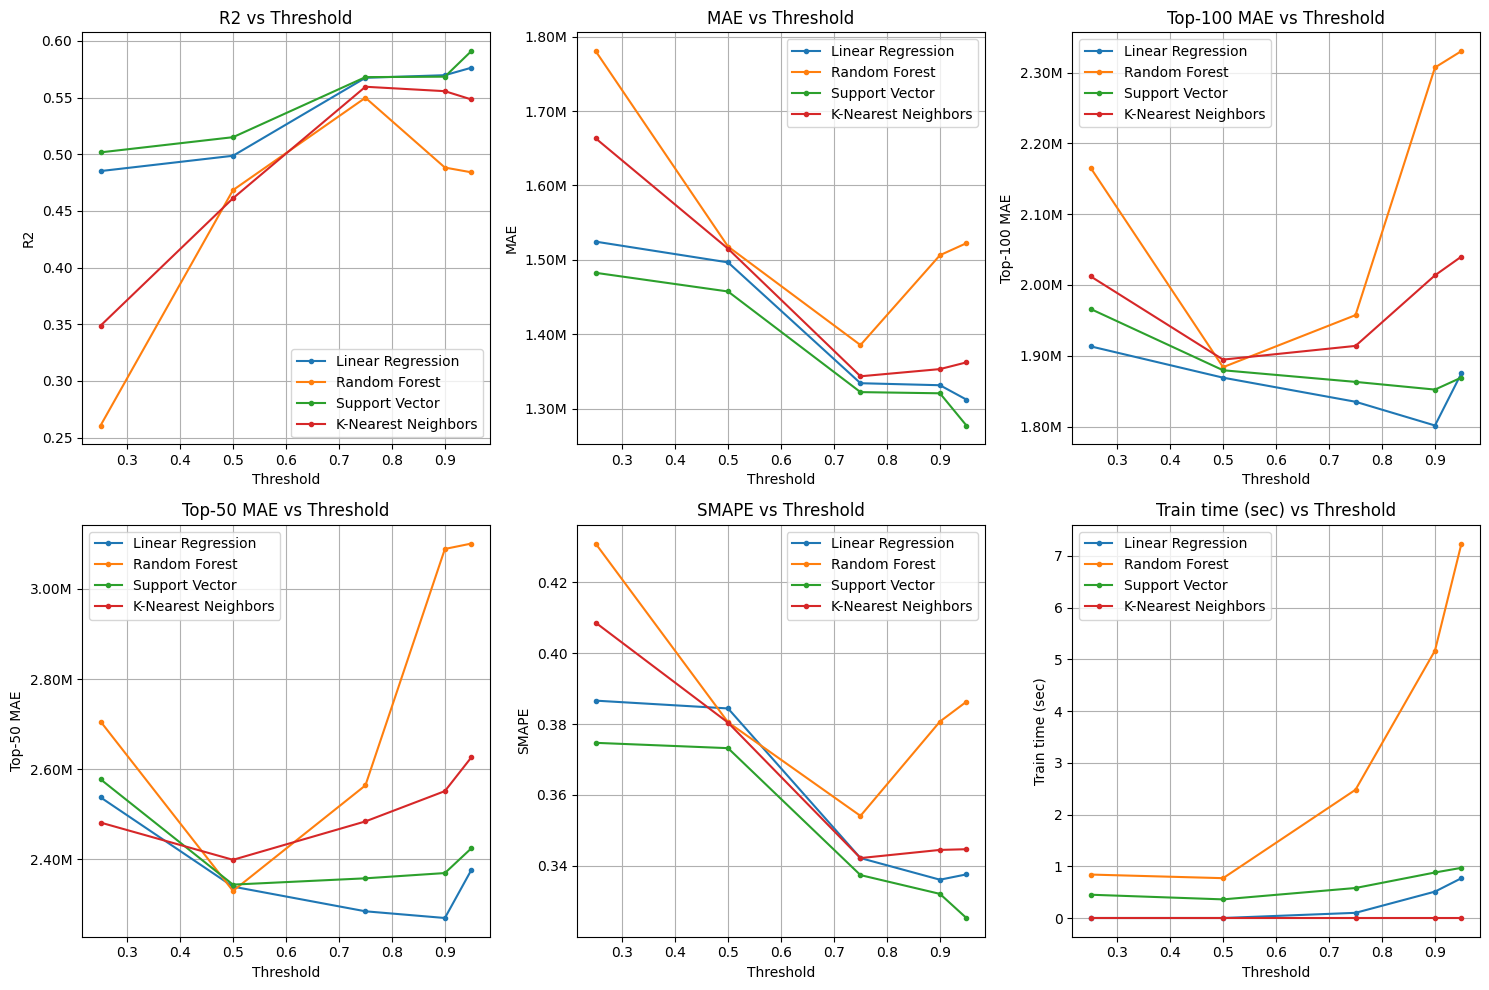

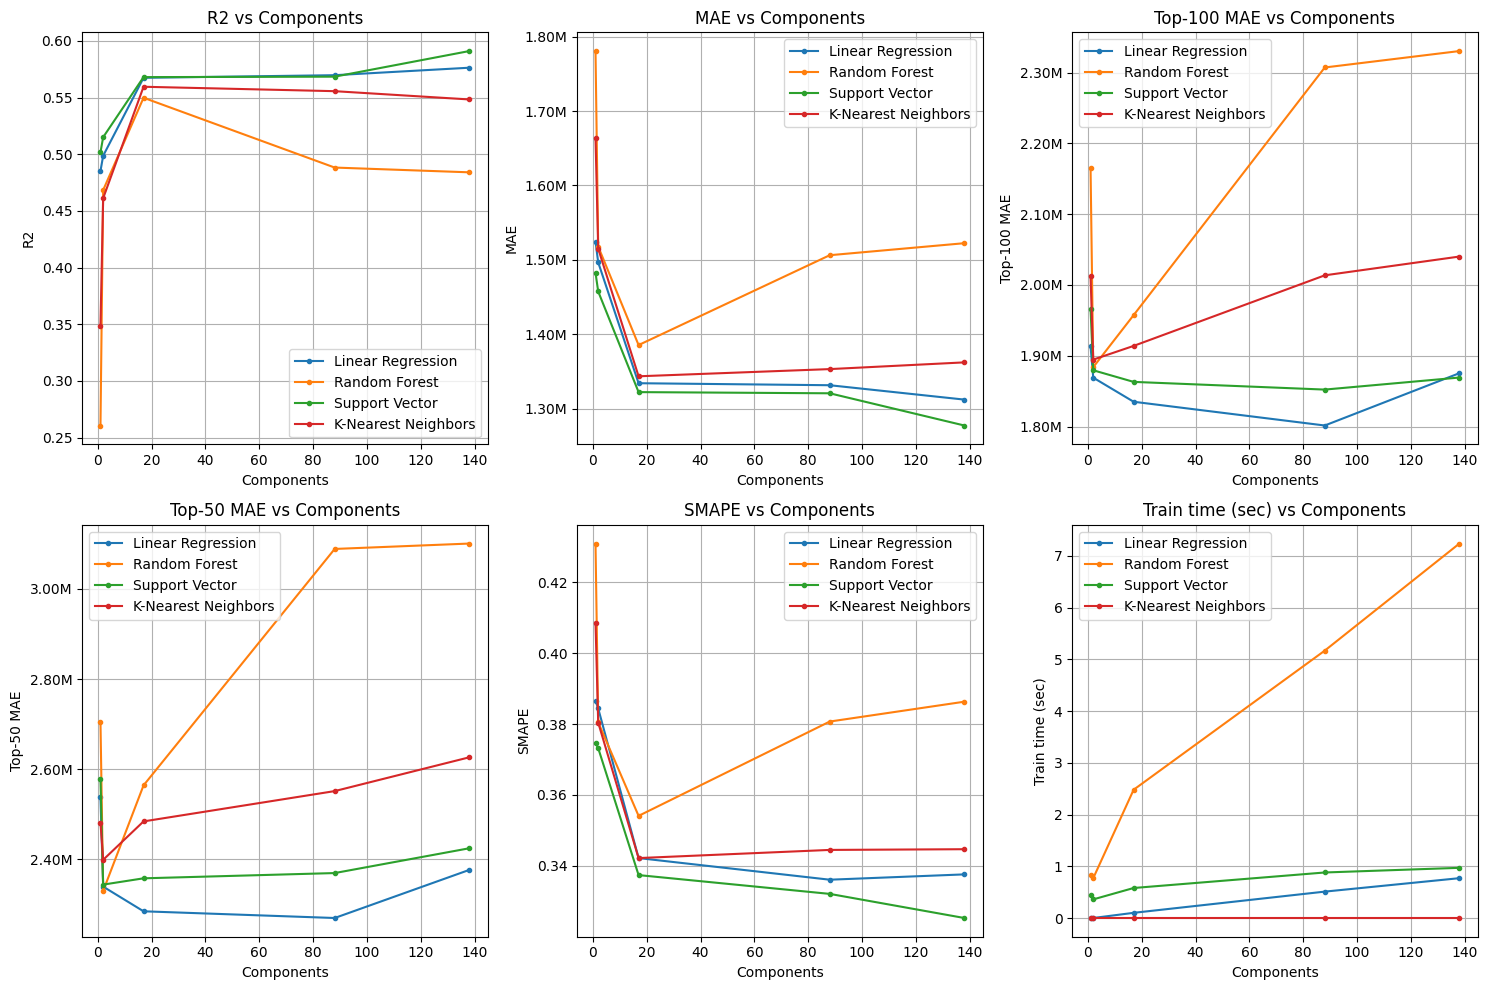

In [54]:
common.plot_metrics(results_df, "Threshold")
common.plot_metrics(results_df, "Components")